# <span style="color: crimson">Определение возраста покупателей</span>
---
**<span style="color: crimson">Заказчик</span>**: cетевой супермаркет «Хлеб-Соль».

**<span style="color: crimson">Цель проекта</span>**: построить модель, которая по фотографии определит приблизительный возраст человека. 

**<span style="color: crimson">Датасет</span>**: набор фотографий людей с указанием возраста.

**Загрузка библиотек.**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

---

**Загрузка датасета.**

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw') 

Found 7591 validated image filenames.


---

**Посмотрим на размер выборки.**

In [3]:
labels.shape

(7591, 2)

---

**График распределения возраста в датасете.**

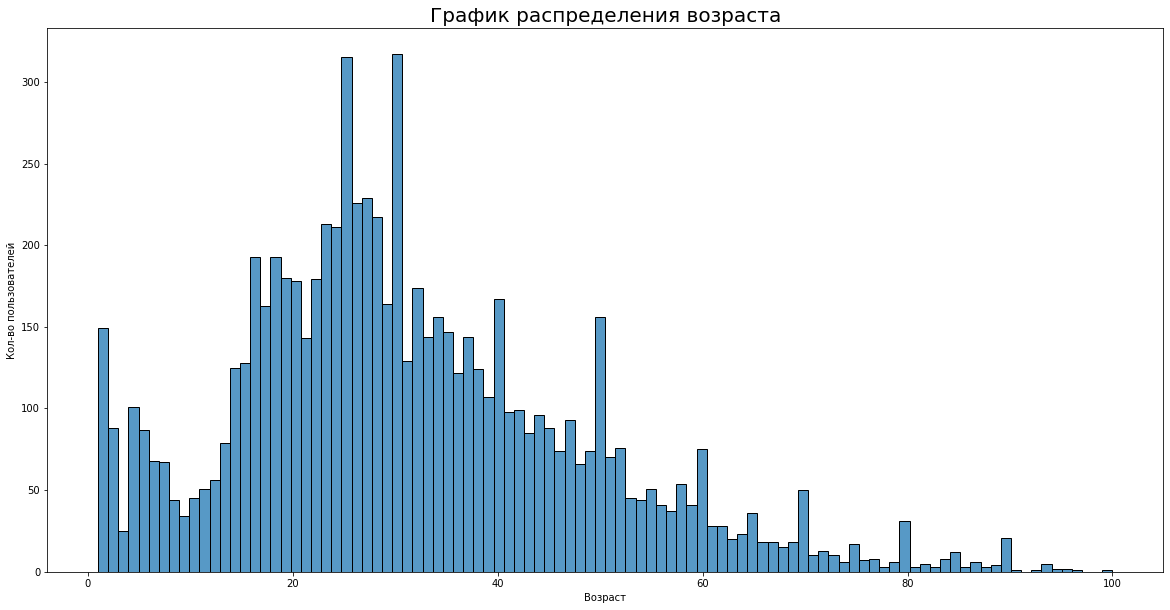

In [4]:
plt.figure(figsize=(20,10))

plot = sns.histplot(labels['real_age'], bins=100)
plot.set_title('График распределения возраста', fontdict={'fontsize':20})
plt.xlabel('Возраст')
plt.ylabel('Кол-во пользователей');

У нас очень маленький набор фото тех кому за 60, как и с 5-10 лет. Если показать все мировое распределение по возрастам, то выборка собрана по закону ЦПТ. 

---

**Отделим целевой от остальных признаков**

In [5]:
features, target = next(datagen_flow)

---

**Взглянем на изображения в наборе**

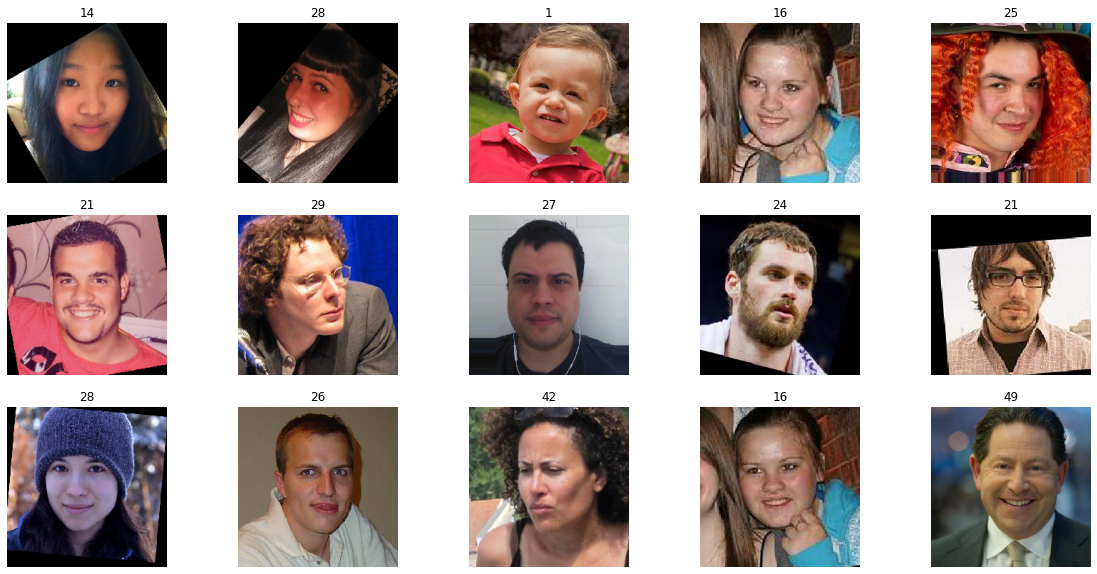

In [6]:
fig = plt.figure(figsize=(20,10))

for i in range(1,16):
    ax = fig.add_subplot(3, 5, i)
    plt.imshow(features[i])
    ax.title.set_text(target[i])
    plt.axis('off')

### <center><span style="color: crimson"><b>Вывод</b></span></center>

Фотографии трансформированы (развернуты на n), имеются как чёрно-белые, так и цветные. Наш набор включает в себя различные разрешения, условия в которых было произведено фото (различные эмоции, позы, задние планы, освещение, как наличие, так и отсутствие очков, есть фотографии, как в профиль, так и в топаз), у некоторых из изображений обрезаны края. Можно заключить, что датасет подходит для работы и обучения в полевых условиях (то есть на реальных фотографиях, а не только на тех, что были сделаны при идеальных условиях, как примеру фотографии на паспорт).

## <span style="color: crimson">Этап 2</span> Обучение моделей

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.25,
        horizontal_flip=True,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2
    )

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=64,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.25
    )

    val_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=64,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return val_datagen_flow




def create_model(input_shape):
    optimizer = Adam(lr=0.0001)


    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())    
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=15, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)

    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              epochs=epochs,
              shuffle=True
              )
    return model

Train for 89 steps, validate for 30 steps  
Epoch 1/15  

89/89 - 167s - loss: 280.0415 - mae: 12.0805 - val_loss: 833.8822 - val_mae: 24.0083  
Epoch 2/15  
89/89 - 96s - loss: 98.0571 - mae: 7.4516 - val_loss: 718.7536 - val_mae: 21.9007    
Epoch 3/15   
89/89 - 95s - loss: 75.1714 - mae: 6.5514 - val_loss: 667.5189 - val_mae: 20.8882  
Epoch 4/15  
89/89 - 94s - loss: 64.1260 - mae: 6.1146 - val_loss: 578.3261 - val_mae: 19.0438  
Epoch 5/15  
89/89 - 94s - loss: 52.9519 - mae: 5.5572 - val_loss: 544.2499 - val_mae: 18.3006  
Epoch 6/15  
89/89 - 94s - loss: 46.0780 - mae: 5.1631 - val_loss: 558.5425 - val_mae: 18.6197  
Epoch 7/15  
89/89 - 94s - loss: 39.8974 - mae: 4.8573 - val_loss: 383.8501 - val_mae: 14.8272  
Epoch 8/15  
89/89 - 95s - loss: 37.8088 - mae: 4.6841 - val_loss: 149.4057 - val_mae: 9.0212  
Epoch 9/15  
89/89 - 95s - loss: 33.9101 - mae: 4.4660 - val_loss: 107.3660 - val_mae: 7.8080  
Epoch 10/15  
89/89 - 95s - loss: 28.8397 - mae: 4.1188 - val_loss: 83.9395 - val_mae: 6.7173  
Epoch 11/15  
89/89 - 95s - loss: 25.6378 - mae: 3.9086 - val_loss: 72.5215 - val_mae: 6.3429  
Epoch 12/15  
89/89 - 94s - loss: 24.7353 - mae: 3.8199 - val_loss: 76.6149 - val_mae: 6.3963  
Epoch 13/15  
89/89 - 95s - loss: 20.8995 - mae: 3.5434 - val_loss: 64.4691 - val_mae: 5.9149  
Epoch 14/15  
89/89 - 96s - loss: 19.4243 - mae: 3.3565 - val_loss: 67.5001 - val_mae: 6.0184  
Epoch 15/15  
89/89 - 94s - loss: 17.7670 - mae: 3.2257 - val_loss: 71.6456 - val_mae: 6.1468  
WARNING:tensorflow:sample_weight modes were coerced from  
  ...  
    to    
  ['...']  
30/30 - 10s - loss: 71.6456 - mae: 6.1468  
Test MAE: 6.1468  

## <span style="color: crimson">Этап 3</span> Анализ обученной модели

Модель  показывается  отклонение в среднем 6 лет. 


**<font color='red'>Проанализируем цели супермаркета «Хлеб-Соль»</font>**

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
 
 - Несмотря на разницу в 6 лет мы все еще можем определить человека в определенную возрастную группу, так что модель помогает достичь этой цели.
 
Контролировать добросовестность кассиров при продаже алкоголя.
    
 - Хорошее направление и оно помогает отсеивать тех, кому точно больше 18 (учитывая возможное отклонение), но вот дети 12 лет (18-6) навряд ли будут покупать алкоголь и сигареты, гораздо эффективнее сканировать паспорт для подтверждения возраста. Так же можно создать отдельную нейронную сеть для определения категории до 18 лет пользователю или более.
    